In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae.jla import *
import simulators.jla_supernovae.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [9]:
### SET UP FOR SIMULATION CODE ###
# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Simulation args for ABC
simABC_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args]

# Compressed dataset
data = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


KeyboardInterrupt: 

In [ ]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [ ]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 1
names = ['\Omega_m', 'w_0', 'M_\mathrm{B}', '\alpha', '\beta', '\delta M']
labels =  ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 31s 682us/step - loss: 14.5294 - val_loss: 9.7550
Epoch 2/50
45000/45000 [==============================] - 38s 845us/step - loss: 9.0055 - val_loss: 8.3416
Epoch 3/50
45000/45000 [==============================] - 34s 766us/step - loss: 7.8585 - val_loss: 7.4378
Epoch 4/50
45000/45000 [==============================] - 38s 849us/step - loss: 7.2455 - val_loss: 7.0926
Epoch 5/50
45000/45000 [==============================] - 33s 726us/step - loss: 7.0110 - val_loss: 6.9239
Epoch 6/50
45000/45000 [==============================] - 33s 732us/step - loss: 6.8985 - val_loss: 6.9044
Epoch 7/50
45000/45000 [==============================] - 32s 700us/step - loss: 6.8449 - val_loss: 6.8364
Epoch 8/50
45000/45000 [==============================] - 30s 664us/step - loss: 6.8023 - val_loss: 6.7866
Epoch 9/50
45000/45000 [==============================] -

Done.


DensitiesError: Contour level outside plotted ranges

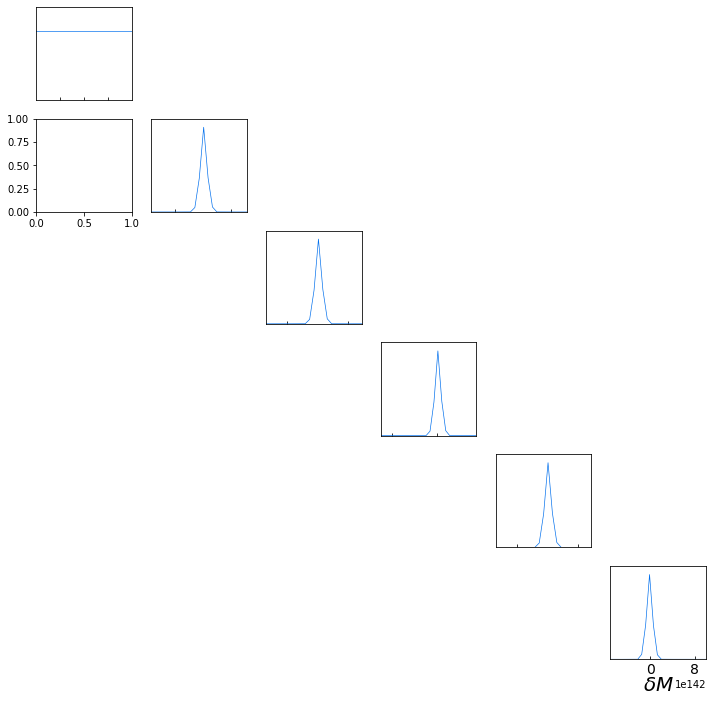

In [7]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

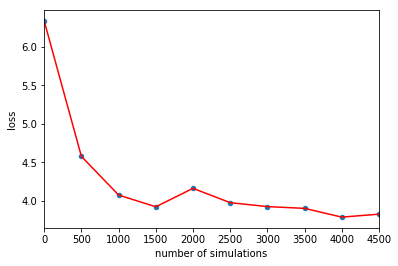

In [10]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()